# Парсинг и анализ ютьюб-канала Alexander Okhrimenko

https://www.youtube.com/channel/UCKDQVR8JJGalvEZBmOfnKhw

Использованы данные за октябрь-декабрь 2017 года (всего 108 видео из списка "ВСЕ ВИДЕО").

In [1]:
# Загрузка библиотек
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import time
from scipy.stats import ttest_ind, spearmanr, pearsonr
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Парсинг

In [14]:
# Ссылка на список видео
link_list = 'https://www.youtube.com/watch?v=FYJ_3GayJPk&list=PL0Z7vG3iXEI9CR_YxqCCVySg2veeY3DdL'

# Парсинг списка
html = urllib.request.urlopen(link_list)
html = BeautifulSoup(html)

# Сохранение ID и заголовка видео в датасет
video_id = []
title = []
for i in re.findall('data-video-id=\".*\"', str(html)):
    video_id.append(re.sub('^data-video-id=\"|" data-video-title.*', '', i))
    title.append(re.sub('.*data-video-title=.|. data-video-username.*', '', i))   
df = pd.DataFrame({
    'video_id': video_id,
    'title': title
})

In [89]:
# Добавление колонок
df['views'] = 'NULL'
df['likes'] = 'NULL'
df['dislikes'] = 'NULL'
df['date'] = 'NULL'
df['tags'] = 'NULL'

In [123]:
# Подделка заголовка
session = requests.Session()
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit 537.36 (KHTML, like Gecko) Chrome",
           "Accept":"text/html,application/xhtml+xml,application/xml; q=0.9,image/webp,*/*;q=0.8"}

In [126]:
# Парсинг
for i in df.video_id[6:]:
    time.sleep(3)
    html = session.get(str('https://www.youtube.com/watch?v='+str(i)), headers=headers)
    html = BeautifulSoup(html.text)
    df.views[df.video_id==i] = ''.join(re.findall('\d', re.sub(r'.*watch-view-count\">| прос.*', '', 
                                                               str(html.find_all('div', class_='watch-view-count')))))   
    df.likes[df.video_id==i] = re.sub('.*yt-uix-button-content\">|</span>', '', 
                                      str(html.find('button', 
                                                    class_='yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-like-button like-button-renderer-like-button-unclicked yt-uix-clickcard-target yt-uix-tooltip').find('span', 
                                                    class_='yt-uix-button-content')))
    df.dislikes[df.video_id==i] = re.sub('.*yt-uix-button-content\">|</span>', '', 
                                         str(html.find('button', 
                                                       class_='yt-uix-button yt-uix-button-size-default yt-uix-button-opacity yt-uix-button-has-icon no-icon-markup like-button-renderer-dislike-button like-button-renderer-dislike-button-unclicked yt-uix-clickcard-target yt-uix-tooltip').find('span', 
                                                       class_='yt-uix-button-content')))
    df.tags[df.video_id==i] = re.sub('.*content=.|. name.*', '', 
                                     str(re.findall('<meta content=\".*\" name=\"keywords\"/>', str(html))))
    df.date[df.video_id==i] = re.sub('.*Опубликовано: | г.*', '', str(html.find_all('strong', class_='watch-time-text')))

In [130]:
# Сохранение датасета
df.to_csv('../data/youtube_okhrimenko.csv', index=False)

## Обработка данных

In [2]:
# Загрузка датасета
df = pd.read_csv('../data/youtube_okhrimenko.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
title       108 non-null object
video_id    108 non-null object
views       108 non-null int64
likes       108 non-null int64
dislikes    108 non-null int64
date        108 non-null object
tags        108 non-null object
dtypes: int64(3), object(4)
memory usage: 6.0+ KB


In [3]:
# Форматирование даты
df.date = df.date.str.replace('^.*Прямой эфир: |$', '')
df.date = df.date.str.replace(' окт. ', '-10-')
df.date = df.date.str.replace(' нояб. ', '-11-')
df.date = df.date.str.replace(' дек. ', '-12-')
df.date = pd.to_datetime(df.date, format='%d-%m-%Y')

In [4]:
# Вычисление доли дизлайков
df['dislikes_per'] = round(df.dislikes/(df.likes+df.dislikes), 2)

In [130]:
df.head()

,title,video_id,views,likes,dislikes,date,tags,dislikes_per
0,"Статистика просмотров видео ""Пару слов о Москв...",FYJ_3GayJPk,1651,146,9,2017-12-17,"Украина, Охрименко, Россия, видео, анализ",0.06
1,Динамика роста/уменьшение населения Украины и ...,3C10V3DW2v0,4545,110,17,2017-12-17,"Украина, Россия, населения России, прирост нас...",0.13
2,Запись Стрима Вечер ответов на вопросы зрителе...,9MjeshE7HvA,2766,93,20,2017-12-16,"Украина, Россия, новости, США, эконономика Укр...",0.18
3,Анонс Стрима Вечер ответов на вопросы зрителей...,wOywbidyZAM,425,16,3,2017-12-16,"Украина, Россия, Охрименко, политика, экономик...",0.16
4,Убойные новости об экспорте Украины и России. ...,WT7I9bcTUjQ,6236,128,62,2017-12-16,"Украина, Россия, Охрименко, экспорт, импорт, э...",0.33


## Анализ данных

### Распределение просмотров и доли дизлайков

In [7]:
# Описательная статистика
df.describe()

,views,likes,dislikes,dislikes_per
count,108.000000,108.000000,108.000000,108.000000
mean,4317.259259,128.185185,16.981481,0.106296
std,4128.096306,85.897586,23.672209,0.108159
min,425.000000,16.000000,0.000000,0.000000
25%,2458.500000,88.000000,4.000000,0.040000
50%,3574.000000,114.000000,9.500000,0.070000
75%,4837.500000,146.250000,19.000000,0.120000
max,31288.000000,785.000000,139.000000,0.550000


In [8]:
print(df.views.median()) # Медиана просмотров

3574.0


In [9]:
print(df.dislikes_per.median()) # Медиана доли дизлайков

0.07


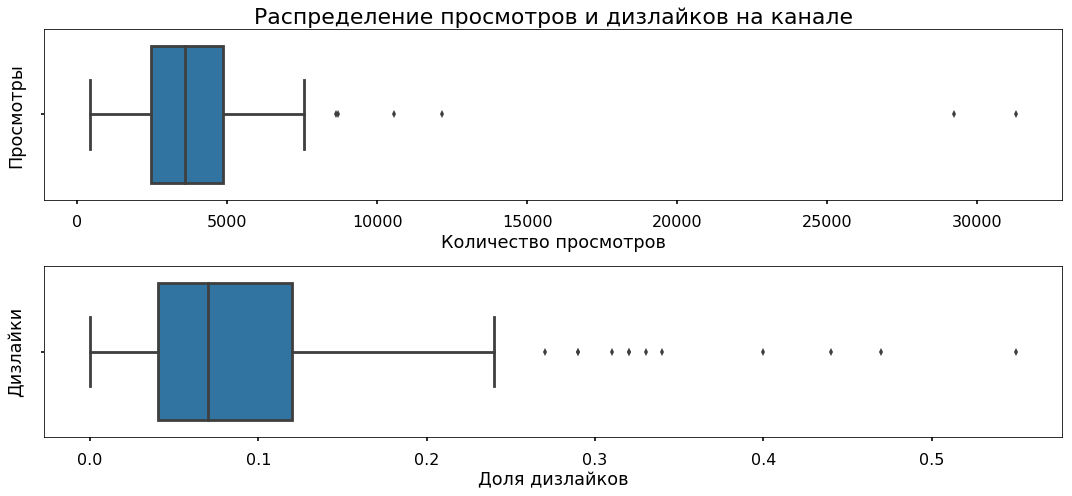

In [38]:
# График "Распределение просмотров и дизлайков"
fig = plt.figure(figsize=[15,7])
plt.subplot(211)
plt.title('Распределение просмотров и дизлайков на канале', fontsize=22)
sns.boxplot(x = 'views', data = df)
plt.ylabel('Просмотры')
plt.xlabel('Количество просмотров')
plt.subplot(212)
sns.boxplot(x = 'dislikes_per', data = df)
plt.xlabel('Доля дизлайков')
plt.ylabel('Дизлайки')
plt.tight_layout()
plt.show()
fig.savefig('../images/Распределение просмотров и дизлайков.png')

In [92]:
# Среднее без выбросов
mean_dis = df.dislikes_per[df.dislikes_per < 0.25].mean() # Дизлайки
mean_views = df.views[df.views < 8000].mean() # Просмотры
print(mean_dis, mean_views)

0.07447916666666664 3585.8039215686276


### Зависимость доли дизлайков от количества просмотров

In [40]:
# Коэффициент Спирмана
spearmanr(df.views, df.dislikes_per)

SpearmanrResult(correlation=0.16868838391086893, pvalue=0.080951506716860369)

In [53]:
# Коэффициент Пирсона
pearsonr(df.views, df.dislikes_per)

(0.10593384651091486, 0.27520238827760651)

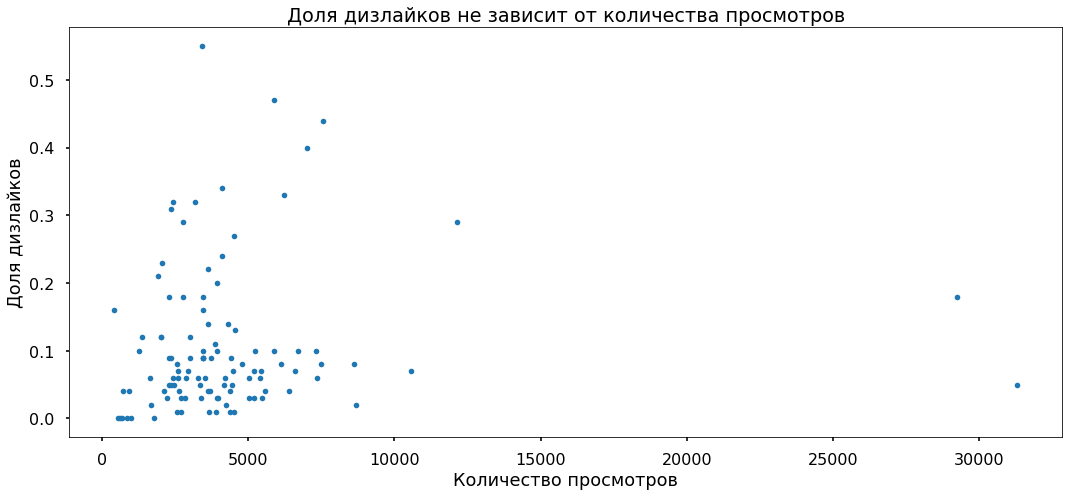

In [42]:
# График "Доля дизлайков не зависит от количества просмотров"
fig = plt.figure(figsize=[15,7])
plt.plot(df.views, df.dislikes_per, '.')
plt.title('Доля дизлайков не зависит от количества просмотров')
plt.xlabel('Количество просмотров')
plt.ylabel('Доля дизлайков')
plt.tight_layout()
plt.show()
fig.savefig('../images/Доля дизлайков не зависит от количества просмотров.png')

### Зависимость доли дизлайков и количества просмотров от тематики видео

In [62]:
# Очистка данных
df.tags = df.tags.str.replace(', мак...', '')

In [135]:
# Распределение просмотров и дизлайков по тегам
dislikes_per = []
views = []
tags = []
for i in range(0, len(df)):
    length = len(df.tags[i].split(','))
    tags += df.tags[i].split(',')
    views += [df.views[i]]*length
    dislikes_per += [df.dislikes_per[i]]*length

df_tags = pd.DataFrame({
    'tags': tags,
    'views': views,
    'dislikes_per': dislikes_per
})

In [137]:
# Очистка данных
df_tags.tags = df_tags.tags.str.replace('^ ', '')

In [65]:
# Топ-20 тегов по частотности употребления (% от общего количества)
df_tags_top = round(df_tags.tags.value_counts()/sum(df_tags.tags.value_counts())*100, 2)[0:20].reset_index()

In [66]:
# Топ-5 тегов по частоте
df_tags_top.head()

,index,tags
0,Украина,9.74
1,Охрименко,6.49
2,Россия,6.28
3,валюта,3.14
4,экономика,2.93


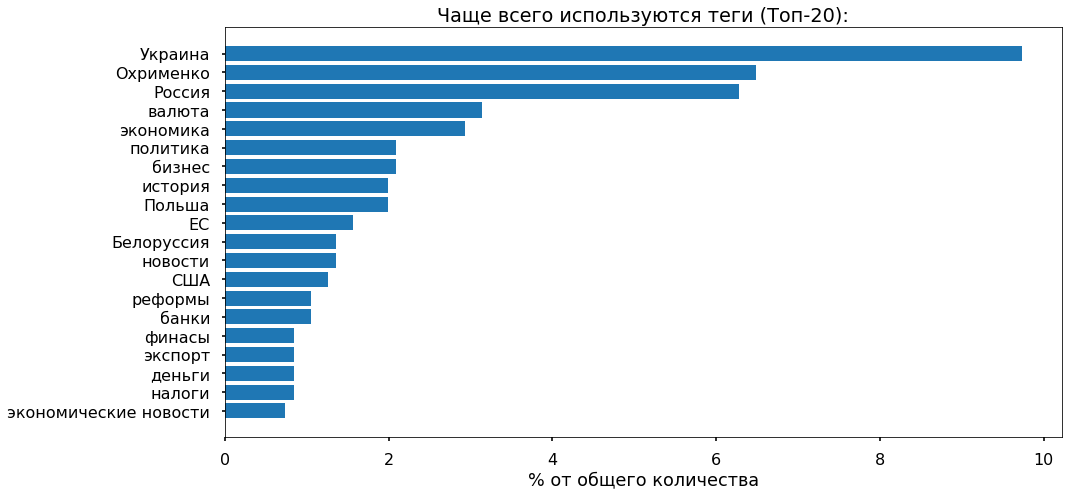

In [67]:
# График "Чаще всего используются теги"
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_tags_top['index']))[::-1], df_tags_top.tags)
ax.set_yticks(np.arange(len(df_tags_top['index']))[::-1])
ax.set_yticklabels(df_tags_top['index'])
plt.title('Importances of Features Plot')
plt.title('Чаще всего используются теги (Топ-20):')
plt.ylabel(' ')
plt.xlabel('% от общего количества')
plt.tight_layout()
plt.show()
fig.savefig('../images/Чаще всего используются теги.png')

In [68]:
# Посты с наибольшей долей дизлайков
df.sort_values(['dislikes_per'], ascending=False).head()

,title,video_id,views,likes,dislikes,date,tags,dislikes_per
18,"Ура! Для всех желающих, есть возможность пожит...",sEOf558czyE,3437,70,86,2017-12-07,"Украина, Россия, социализм, капитализм, Охриме...",0.55
59,Импортозамещение в России: успех или провал..И...,UFGApGeeVpc,5891,158,139,2017-11-16,"Украина, Россия, импортозамещение, импорт",0.47
107,"Кто выиграет, а кто проиграет от Медицинской р...",7FkYR9cVmzk,7548,128,100,2017-10-20,"Украина, медицина, болезни, врачи, лекарства, ...",0.44
40,Афера по-российски: самолеты «Sukhoi SuperJet ...,F-8J5QaqWFQ,6998,143,96,2017-11-26,"Россия, самолетостроение, «Sukhoi SuperJet 100...",0.40
57,Импортозамещение в Украине на примере велосипе...,tQm8FKGC_SU,4119,73,37,2017-11-17,"Украина, импортозамещение, велосипеды, Охримен...",0.34


In [69]:
# Посты с наименьшей долей дизлайков
df.sort_values(['dislikes_per'], ascending=True).head()

,title,video_id,views,likes,dislikes,date,tags,dislikes_per
21,Анонс Стрима Вечер ответов на вопросы зрителей...,-MEb-3QOd6U,545,27,0,2017-12-06,"Украина, Россия, политика, экономика, Охрименк...",0.0
55,Как я готовлю кофе и приглашаю Вас сегодня на ...,Xb32ctGjv8Q,1009,55,0,2017-11-18,"Украина, Россия, Польша, новости, стрим, Охрим...",0.0
70,Анонс Стрима Вечер ответов на вопросы зрителей...,325mKdScBxw,697,30,0,2017-11-11,"Украина, Россия, Польша, Белоруссия, Казахстан...",0.0
84,"Анонс Стрима ""Вечер ответов на вопросы зрителе...",Cohcejz3slo,843,34,0,2017-11-04,"Украина, Россия, Польша, Белоруссия, Казахстан...",0.0
90,Несколько слов о валютном рынке Украины за 9 м...,dMecZClVZBc,1768,40,0,2017-11-01,"Украина, платежный баланас, валюта, валютный р...",0.0


In [101]:
# Посты с наибольшим количеством просмотров
df.sort_values(['views'], ascending=False).head()

,title,video_id,views,likes,dislikes,date,tags,dislikes_per
34,"Александр Охрименко и Дмитрий Джангиров, ""Рабо...",9-UJYYmxDpc,31288,785,40,2017-11-28,"Капитал, Капитал ТВ, Capital, CapitalTV, Украи...",0.05
11,Кто спасет Украину? Право голоса,PAEnK6NSfxM,29224,272,58,2017-12-12,"ТВЦ, ТВ Центр, ток-шоу, Бабаян, политика, экон...",0.18
5,Пару слов о Москве глазами хохла,LyB1TCAbJ4U,12152,294,118,2017-12-15,"Украина, Россия, Киев, Москва, Охрименко, исто...",0.29
33,США добавил санкций против России и уже пугают...,-8R-F288ulo,10561,263,19,2017-11-29,"Россия, Охрименко, валюта, США, санкции против...",0.07
94,Действительно ли Украина кормит ЕС?. Цифры и ф...,COHJjK4vsfM,8679,156,4,2017-10-29,"Украина, ЕС, экспорт, экспорт Украины в ЕС, эк...",0.02


#### Вычисление значимой зависимости (t-тест)

In [119]:
# Среднее значение просмотров и доли дизлайков по тегам, которые встречаются с частотой >= 5
df_ttest = df_tags.groupby('tags')['views', 'dislikes_per'].mean().sort_values(['dislikes_per'], ascending=False)
top_tags = df_tags.tags.value_counts()[df_tags.tags.value_counts() >= 5].reset_index()['index'].tolist()
df_ttest = df_ttest[df_ttest.index.isin(top_tags)]

In [120]:
# Добавление колонок для уровня значимости t-теста и отклонений от средних значений
df_ttest['views_pvalue'] = 1 # pvalue для просмотров
df_ttest['dislikes_pvalue'] = 1 # pvalue для дизлайков
df_ttest['views_diff_mean'] = round((df_ttest.views-mean_views)/mean_views, 2) # отклонение от ср. просмотров
df_ttest['dislikes_diff_mean'] = round((df_ttest.dislikes_per-mean_dis)/mean_dis, 2) # отклонение от ср. доли дизов

In [121]:
# Расчет p-value
for i in df_ttest.index:
    df_ttest.dislikes_pvalue[df_ttest.index==i] = ttest_ind(df.dislikes_per[df.tags.str.contains(str(i))].tolist(), 
                                                         [df.dislikes_per.mean()]*len(df.dislikes_per[df.tags.str.contains(str(i))].tolist()))[1]
    df_ttest.views_pvalue[df_ttest.index==i] = ttest_ind(df.views[df.tags.str.contains(str(i))].tolist(), 
                                                         [df.views.mean()]*len(df.views[df.tags.str.contains(str(i))].tolist()))[1]

In [122]:
# Теги, которые оказывают значимое влияние на количество просмотров (значимо отклоняются от среднего - 3585.8)
df_ttest[df_ttest.views_pvalue <= 0.05].sort_values(['views'], ascending=False)

,views,dislikes_per,views_pvalue,dislikes_pvalue,views_diff_mean,dislikes_diff_mean
tags,,,,,,
Охрименко,3753.258065,0.111290,3.094395e-02,7.820253e-01,0.05,0.49
эконономика Украины,3473.857143,0.095714,7.858082e-04,5.582859e-01,-0.03,0.29
экономические новости,3473.857143,0.095714,7.858082e-04,5.582859e-01,-0.03,0.29
реформы,3317.900000,0.078000,1.361012e-02,8.942985e-02,-0.07,0.05
Польша,3231.631579,0.065789,2.136040e-03,2.250849e-03,-0.10,-0.12
Белоруссия,3222.461538,0.067692,3.839745e-02,9.053374e-03,-0.10,-0.09
бизнес,2975.200000,0.082000,2.300041e-05,8.004091e-02,-0.17,0.10
новости,2497.538462,0.066923,8.963694e-03,5.330756e-03,-0.30,-0.10
СССР,2106.714286,0.194286,3.512163e-08,2.760130e-02,-0.41,1.61


In [123]:
# Теги, которые оказывают значимое влияние на долю дизлайков (значимо отклоняются от среднего - 0.07)
df_ttest[df_ttest.dislikes_pvalue <= 0.05].sort_values(['dislikes_per'], ascending=False)

,views,dislikes_per,views_pvalue,dislikes_pvalue,views_diff_mean,dislikes_diff_mean
tags,,,,,,
СССР,2106.714286,0.194286,3.512163e-08,2.760130e-02,-0.41,1.61
США,4301.000000,0.075000,9.715244e-01,1.068518e-02,0.20,0.01
политика,3911.900000,0.074000,7.717820e-01,1.658367e-02,0.09,-0.01
Белоруссия,3222.461538,0.067692,3.839745e-02,9.053374e-03,-0.10,-0.09
новости,2497.538462,0.066923,8.963694e-03,5.330756e-03,-0.30,-0.10
Польша,3231.631579,0.065789,2.136040e-03,2.250849e-03,-0.10,-0.12
валюта,3587.433333,0.058333,8.526937e-02,5.956212e-07,0.00,-0.22
курс доллара,4206.400000,0.054000,8.892282e-01,2.279151e-02,0.17,-0.27
зарплата,4086.166667,0.051667,5.998981e-01,1.199701e-03,0.14,-0.31


## Выводы

* Среднее количество просмотров на канале после удаление экстремальных значений -- 3585 (без удаления -- 4317, медианное значение равно 3574), средний процент дизлайков после удаления экстремальных значений -- 7% (без удаления -- 11%, медиана -- 7%). Для канала, который освещает довольно сложные, зачастую болезненные для общества темы, -- очень хороший результат.

* Прямой зависимости между количеством просмотров и доли дизлайков нет.

* Есть значимая зависимость доли дизлайков от тематики видео:

  + Людям нравятся прогнозы и советы автора по экономическим и бизнес-вопросам, которые их непосредственно касаются (теги "курс гривны", "зарплата", "курс доллара", "валюта", отчасти "бизнес", "банки", "деньги").

  + Стримы аудитория оценивает в основном положительно (теги "деньги", "финансы", "банки").

  + Очень не нравятся аудитории видео с тегом "СССР" -- дизлайков под такими роликами на 160% больше среднего -- из-за резкого неприятия позиции автора (точки преткновения: советское прошлое, история Руси, стратегическое видение будущего).

* Зависимость количества просмотров от тематики менее выражена (существенное влияние оказывают множество других факторов):

  + Видео с тегами "новости", "деньги", "финансы", "бизнес" имеют значимо меньше просмотров, но не из-за тематики, а специфики формата -- под ними идут в основном анонсы стримов, которые имеют малую информативность, и сами стримы, которые не все могут досмотреть полностью из-за большой продолжительности.

  + Ролики с тегом "СССР" имеют просмотров на 40% меньше среднего -- из-за негативного отношения аудитории к мнению автора по данному вопросу.
  
При ознакомлении с выводами следует понимать:

1. Теги довольно поверхностно отражают содержание видео;
2. На просмотры и дизлайки влияют множество взаимосвязанных друг с другом факторов, которые здесь не учитываются;
3. Использована довольно малая выборка.

In [142]:
# Сохранение обработанного датасета
df.to_csv('../data/youtube_okhrimenko_final.csv')